In [1]:
#import sys
#sys.path.insert(0, '../')
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
from src.data.access import DbAccessLayer, ExternalDataAccessLayer
#from src.data.maintenance import RawData, Database
import warnings
from src.selection.evaluation import create_train_test
from tqdm import tqdm
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [23]:
from src.data.maintenance import Database, RawData
from src.data.access import RawDataAccessLayer
RawData().prepare()
Database().create_matches_table()

In [2]:
from src.features.generation import FeaturesLabelsGenerator
generator = FeaturesLabelsGenerator()

In [6]:
generator.get_form(5)

Adding before outcomes: 100%|██████████| 214/214 [00:42<00:00,  5.03it/s]


In [7]:
generator.get_form(5, site_specific=True)

Adding before outcomes: 100%|██████████| 214/214 [00:59<00:00,  3.62it/s]


In [52]:
generator.get_bookmaker_pred()

In [48]:
from tqdm import tqdm
import numpy as np


def add_before_outcomes(df: pd.DataFrame, n_before: int):
    """Adds the n outcomes of the prior matches of the home and away team."""
    before_cols = [f'home_before_{i+1}' for i in range(n_before)] + [f'away_before_{i+1}' for i in range(n_before)]

    # Create columns and set to NaN
    for col in before_cols:
        df[col] = np.NaN

    def fill_before_outcomes(team_id: int):
        """Fills the before outcomes of a given team."""
        team_match_df = df[(df['home_team_id'] == team_id) | (df['away_team_id'] == team_id)]
        if len(team_match_df) > 0:
            team_match_df['team_role'] = team_match_df['home_team_id'].apply(lambda ht: 'H' if ht == team_id else 'A')
            team_match_df['outcome'] = team_match_df.apply(
                lambda r: 1 if r['result'] == r['team_role'] else 0 if r['result'] == 'D' else -1, axis=1)
            for i in range(n_before):
                n = i+1
                team_match_df[f'before_{n}'] = team_match_df['outcome'].shift(n)

            for i, row in team_match_df.iterrows():
                for col in before_cols:
                    row_role = 'home' if row['team_role'] == 'H' else 'away'
                    col_role = col[:4]
                    if row_role == col_role:
                        df.loc[i, col] = row[col[5:]]

    all_teams = set(df['home_team_id'].unique().tolist() + df['away_team_id'].unique().tolist())
    for team in tqdm(all_teams, desc="Adding before outcomes"):  # for each team, fill the outcomes
        fill_before_outcomes(team)
    return df


def add_form(df):
    """Add the form as a weighted average of the before outcomes where recent outcomes have more weight."""
    all_cols = df.columns.tolist()
    before_cols = [col for col in all_cols if col[5:11] == 'before']
    home_before_cols = [col for col in before_cols if col[:4] == 'home']
    away_before_cols = [col for col in before_cols if col[:4] == 'home']
    df['home_form'] = (df[home_before_cols] * [len(home_before_cols)-i for i in range(len(home_before_cols))]).sum(axis=1)
    df['away_form'] = (df[away_before_cols] * [len(away_before_cols) - i for i in range(len(away_before_cols))]).sum(axis=1)
    return df


def get_bookmaker_pred(df: pd.DataFrame) -> pd.Series:
    """Gets the prediction the bookmaker would have made. Configured for Bet365 as bookmaker."""
    bookmaker_pred = df[['b365_H', 'b365_D', 'b365_A']].idxmin(axis=1).str[-1:]
    return bookmaker_pred


def get_outcome_counts(df_in: pd.DataFrame) -> pd.DataFrame:
    """Counts the number of wins, draws, and losses per home team in the prior n matches where n is the number of
    columns that capture prior results (these columns must already exist in DataFrame."""
    df = df_in.copy()
    sites = ['home', 'away']
    outcome_df = pd.DataFrame()
    for site in sites:
        before_cols = [col for col in df.columns if col[:11] == f'{site}_before']
        wins = (df[before_cols] == 1).sum(axis=1)
        draws = (df[before_cols] == 0).sum(axis=1)
        losses = (df[before_cols] == -1).sum(axis=1)
        outcome_df[f"{site}_wins"] = wins
        outcome_df[f"{site}_draws"] = draws
        outcome_df[f"{site}_losses"] = losses
    return outcome_df

db_access = DbAccessLayer()
match_df = db_access.load_table('Match')
odds_df = db_access.load_table('Odds')
odds_df.drop_duplicates(subset=['match_id'], inplace=True)
match_df = match_df.merge(odds_df.drop(columns=['id']), on='match_id')
match_df = add_before_outcomes(match_df, 15)
match_df = add_form(match_df)
match_df['bookmaker_pred'] = get_bookmaker_pred(match_df)
#match_df['rel_attendance'] = get_relative_attendance(match_df)
#match_df['attendance_coef'] = get_attendance_coef(match_df)
match_df = pd.concat([match_df, get_outcome_counts(match_df)], axis=1)
match_df

Adding before outcomes: 100%|██████████| 211/211 [02:33<00:00,  1.37it/s]


,match_id,league_id,season,matchday,date,time,home_team_id,away_team_id,table_position_home,table_position_away,...,away_before_15,home_form,away_form,bookmaker_pred,home_wins,home_draws,home_losses,away_wins,away_draws,away_losses
0,55436,GB1,06/07,1,2006-08-19 00:00:00,12:45 PM,350,31,17,3,...,NaN,0.0,0.0,A,0,0,0,0,0,0
1,55437,GB1,06/07,1,2006-08-19 00:00:00,3:00 PM,11,405,4,11,...,NaN,0.0,0.0,H,0,0,0,0,0,0
2,55438,GB1,06/07,1,2006-08-19 00:00:00,3:00 PM,29,1010,7,20,...,NaN,0.0,0.0,H,0,0,0,0,0,0
3,55439,GB1,06/07,1,2006-08-20 00:00:00,1:30 PM,985,931,1,16,...,NaN,0.0,0.0,H,0,0,0,0,0,0
4,55440,GB1,06/07,1,2006-08-19 00:00:00,3:00 PM,379,358,15,19,...,NaN,0.0,0.0,H,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33215,3615128,IT1,21/22,25,2022-02-14 00:00:00,7:45 PM,3522,430,15,8,...,-1.0,-31.0,-31.0,A,4,2,9,7,2,6
33216,3718405,IT1,21/22,19,2021-12-22 00:00:00,5:30 PM,12,1038,6,15,...,-1.0,5.0,5.0,H,6,6,3,4,1,10
33217,3718646,IT1,21/22,19,2021-12-22 00:00:00,5:30 PM,276,430,13,7,...,1.0,-7.0,-7.0,A,5,6,4,8,2,5
33218,3719028,IT1,21/22,19,2021-12-22 00:00:00,7:45 PM,6195,3522,2,17,...,-1.0,49.0,49.0,H,8,4,3,4,1,10


In [49]:
sites = ['home', 'away']
#features = [f'home_before_{i+1}' for i in range(5)] + [f'away_before_{i+1}' for i in range(5)] + ['home_form', 'away_form'] + [f"{s}_losses" for s in sites] + [f"{s}_draws" for s in sites] + [f"{s}_wins" for s in sites] + ['table_position_home'] + ['table_position_away'] + ['rel_attendance'] + ['attendance_coef']

features = ['home_form', 'away_form'] + [f"{s}_losses" for s in sites] + [f"{s}_draws" for s in sites] + [f"{s}_wins" for s in sites] + ['table_position_home'] + ['table_position_away'] #+ ['rel_attendance']# + ['attendance_coef']

X_train, X_test, y_train, y_test = create_train_test(df_in=match_df, split_date='2022-01-01', start_date='2010-07-01', features=features)#, leagues=['L1'])
len(X_train)

24348

In [66]:
db_access = DbAccessLayer()
X, y = db_access.get_features_labels()
match_df = X.merge(y, on='id')
match_df['date'] = X.index
bookmaker_pred = db_access.load_table('Features')['bookmaker_pred'].astype(str)

features= [
    'form_home',
    'form_away',
    'site_form_home',
    'site_form_away'
]

X_train, X_test, y_train, y_test = create_train_test(df_in=match_df, split_date='2022-01-01', start_date='2010-07-01', features=features)#, leagues=['L1'])
len(X_train)

24408

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix
model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
confusion_matrix(y_test, y_pred)

Accuracy: 0.42


array([[110,  64, 177],
       [ 77,  57, 136],
       [ 87,  84, 283]], dtype=int64)

In [50]:
importances = pd.Series(index=X_train.columns, data=model.feature_importances_).sort_values(ascending=False)
importances

form_away         0.258481
form_home         0.250809
site_form_away    0.248703
site_form_home    0.242008
dtype: float64

In [67]:
bookmaker_pred_test = bookmaker_pred.loc[y_test.index]
print(f"Bookmaker Accuracy: {round(accuracy_score(y_test, bookmaker_pred_test), 2)}")
confusion_matrix(y_test, bookmaker_pred_test)

Bookmaker Accuracy: 0.52


array([[198,   0, 152,   1],
       [102,   0, 168,   0],
       [ 90,   0, 363,   1],
       [  0,   0,   0,   0]], dtype=int64)

KeyError: 'b365_H'

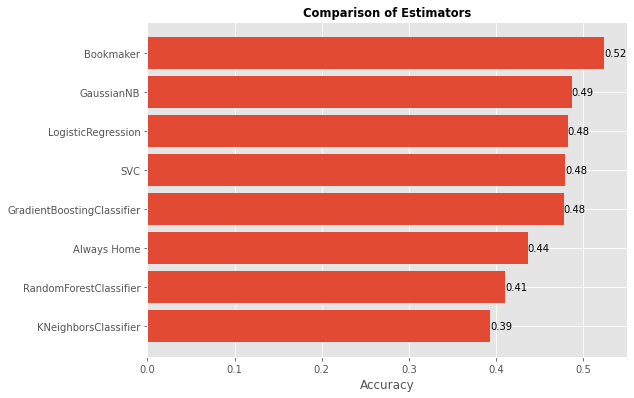

In [69]:
from src.selection.evaluation import compare_estimators
tested_models = [
    RandomForestClassifier(n_estimators=500),
    LogisticRegression(),
    GradientBoostingClassifier(),
    GaussianNB(),
    SVC(probability=True),
    KNeighborsClassifier()
]
bookmaker_pred_train = bookmaker_pred.loc[X_train.index]
compare_estimators(tested_models, X_train, y_train, match_df, bookmaker_pred_train)

SVC


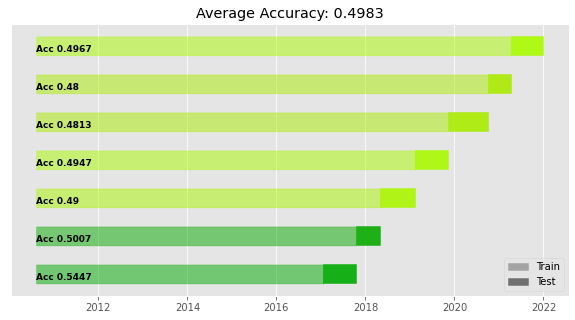

In [56]:
from src.selection.evaluation import temp_cross_validate
train_dates = match_df.loc[X_train.index]['date']
tested = [SVC(),
          #SVC(C=0.8),
          #SVC(C=1.2),
          #SVC(kernel='linear'),
          #SVC(kernel='poly'),
          #SVC(kernel='poly', degree=2),
]
for m in tested:
    print(m.__class__.__name__)
    _ = temp_cross_validate(m, X_train, y_train, visualize=True, dates=train_dates)

# Scraper

In [2]:
from src.scraper import Scraper
scraper = Scraper()

In [5]:
#scraper.get_match_data(seasons=[2019], leagues=["FR1"], matchdays=[29, 30, 31, 32, 33, 34, 35, 36, 37, 38])
scraper.get_match_data(seasons=[2015], leagues=["ES1", "IT1", "FR1"], matchdays=38)

In [10]:
scraper.fill_missing_team_data()

Getting team data: 100%|██████████| 4/4 [00:27<00:00,  6.95s/it]


In [24]:
from src.data.access_old import DbAccessLayer as DbAccessLayerOld
teams_df = DbAccessLayer().load_table('Team')
odds_df = DbAccessLayerOld().load_table('Match')
old_teams_df = DbAccessLayerOld().load_table('Team')

In [7]:
from src.data.access_old import DbAccessLayer as DbAccessLayerOld
old_teams_df = DbAccessLayerOld().load_table('Team')
old_teams_df.to_csv("old_teams.csv")

# Odds Creation

In [24]:
from src.data.access_old import DbAccessLayer as DbAccessLayerOld
db_access = DbAccessLayer()
match_df = db_access.load_table("Match")
odds_relation = db_access.load_table("TeamOdds")
odds_df = db_access.load_table("MatchSecondary")

In [25]:
match_df_adj = match_df.copy()
match_df_adj['date'] = pd.to_datetime(match_df_adj['date'])
odds_df['Date'] = pd.to_datetime(odds_df['Date'])
odds_df.dropna(subset=['HomeTeam', 'AwayTeam'], inplace=True)
match_df_adj = match_df_adj.merge(odds_relation[['team_id', 'odds_team_name']], left_on="home_team_id", right_on="team_id").rename(columns={'odds_team_name': 'odds_team_name_home'}).drop(columns=['team_id'])
match_df_adj = match_df_adj.merge(odds_relation[['team_id', 'odds_team_name']], left_on="away_team_id", right_on="team_id").rename(columns={'odds_team_name': 'odds_team_name_away'}).drop(columns=['team_id'])
match_df_adj = match_df_adj.merge(odds_df, left_on=['date', 'odds_team_name_home', 'odds_team_name_away'], right_on=['Date', 'HomeTeam', 'AwayTeam'], how='left')
match_df_adj = match_df_adj.sort_values('Date').drop_duplicates(subset=['match_id'])
valid_matches = match_df_adj.dropna(subset=['B365H', 'B365D', 'B365A'])
valid_matches

,match_id,league_id,season,matchday,date,time,home_team_id,away_team_id,table_position_home,table_position_away,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2,HFKC,AFKC
6080,57656,FR1,06/07,1,2006-08-04,8:00 PM,995,1041,20,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8513,57662,FR1,06/07,1,2006-08-05,7:00 PM,1164,417,12,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8770,57659,FR1,06/07,1,2006-08-05,7:00 PM,583,1158,15,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6483,57657,FR1,06/07,1,2006-08-05,4:15 PM,273,1082,4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7267,57660,FR1,06/07,1,2006-08-05,7:00 PM,1159,162,13,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13819,3611510,ES1,21/22,38,2022-05-22,9:00 PM,131,1050,2,7,...,1.85,2.09,2.00,1.97,1.91,NaN,NaN,NaN,NaN,NaN
18258,3611515,ES1,21/22,38,2022-05-22,9:00 PM,368,621,4,8,...,1.90,2.07,2.06,2.00,1.88,NaN,NaN,NaN,NaN,NaN
20460,3614917,IT1,21/22,38,2022-05-22,8:00 PM,607,1390,20,18,...,2.06,1.97,2.22,1.79,2.09,NaN,NaN,NaN,NaN,NaN
21143,3614913,IT1,21/22,38,2022-05-22,8:00 PM,380,410,17,12,...,2.04,1.93,2.04,1.89,1.99,NaN,NaN,NaN,NaN,NaN


In [34]:
db_access.save_odds(valid_matches)

In [26]:
missing_ratio = (len(match_df_adj) - len(valid_matches)) / len(match_df_adj)
print(f"Missing values: {round(missing_ratio*100, 2)}%")

Missing values: 0.2%


In [27]:
non_match = match_df_adj[match_df_adj['Date'].isna()]
non_match

,match_id,league_id,season,matchday,date,time,home_team_id,away_team_id,table_position_home,table_position_away,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2,HFKC,AFKC
51,55685,GB1,06/07,25,2007-01-31,8:45 PM,379,31,18,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,55660,GB1,06/07,23,2007-01-13,4:00 PM,29,1032,10,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
972,55666,GB1,06/07,24,2007-01-20,4:00 PM,11,985,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,55693,GB1,06/07,26,2007-02-03,4:00 PM,148,985,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1274,55646,GB1,06/07,22,2007-01-01,4:00 PM,11,358,6,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1281,55677,GB1,06/07,25,2007-01-30,8:45 PM,355,358,5,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2557,55610,GB1,06/07,18,2006-12-16,4:00 PM,281,148,11,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2831,55675,GB1,06/07,24,2007-01-20,4:00 PM,1071,29,17,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3108,55663,GB1,06/07,23,2007-01-13,4:00 PM,148,762,7,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6081,912905,FR1,08/09,17,2008-12-06,8:00 PM,995,1041,16,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
teams_df

NameError: name 'teams_df' is not defined

In [30]:
col = 'home_team_id'
teams_df = db_access.load_table("Team")
odds_teams_df = db_access.load_table('TeamOdds')
non_match[col].value_counts().to_frame().join(teams_df.set_index('team_id')['name']).join(odds_teams_df.set_index('team_id')['odds_team_name']).sort_values(col, ascending=False).rename(columns={col: 'na_count'})

,na_count,name,odds_team_name
13,4,Atlético de Madrid,Ath Madrid
862,4,Chievo Verona,Chievo
1049,2,Valencia CF,Valencia
995,2,FC Nantes,Nantes
11,2,Arsenal FC,Arsenal
131,2,FC Barcelona,Barcelona
142,2,Real Zaragoza,Zaragoza
148,2,Tottenham Hotspur,Tottenham
1050,2,Villarreal CF,Villarreal
368,2,Sevilla FC,Sevilla


### Neural Network Classifier

In [76]:
from src.estimators.neural_network import NeuralNetworkClassifier
ann = NeuralNetworkClassifier()

Experimental


In [77]:
hist = ann.fit(X_train, y_train, epochs=10)#, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
761/761 [==============================] - 3s 3ms/step - loss: 1.0365 - accuracy: 0.4830
Epoch 2/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0227 - accuracy: 0.4933
Epoch 3/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0179 - accuracy: 0.4961
Epoch 4/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0174 - accuracy: 0.4976
Epoch 5/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0169 - accuracy: 0.4981
Epoch 6/10
761/761 [==============================] - 3s 3ms/step - loss: 1.0158 - accuracy: 0.5000
Epoch 7/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0154 - accuracy: 0.4983
Epoch 8/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0152 - accuracy: 0.4982
Epoch 9/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0149 - accuracy: 0.4983
Epoch 10/10
761/761 [==============================] - 2s 3ms/step - loss: 1.0148 - accuracy: 0.5006

In [1]:
ann.score(X_test, y_test)

NameError: name 'ann' is not defined

In [79]:
ann.summary()

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'summary'

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

def build_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(6, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(3, kernel_initializer='glorot_uniform', activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

ann_cust = KerasClassifier(build_fn=build_model, epochs=10)

temp_cross_validate(ann_cust, X_train, y_train, visualize=True, dates=train_dates)

In [ ]:
hist = ann_cust.fit(X_train, y_train, epochs=50)
ann_cust.score(X_test, y_test)

In [ ]:
pd.DataFrame(hist.history_).plot()

In [ ]:
compare_estimators([ann_cust], X_train, y_train, match_df, bookmaker_pred)